## Step 1. EDA

1.1 Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
%matplotlib inline

DATA_DIR = os.path.join(os.getcwd(), "../data")
fn = os.path.join(DATA_DIR, "heart_disease_uci.csv") 
print("Data file:", fn)

Data file: /Users/konstantinoskalaitzidis/Developer/heart-disease-prediction/notebooks/../data/heart_disease_uci.csv


1.2 Load dataset and preview

In [2]:
df = pd.read_csv(fn)
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


1.3 quick overview

In [3]:
print(df.shape)           # rows, columns
print(df.columns.tolist())# feature names
print(df.info())          # data types and non-null counts
print(df.describe())      # summary statistics

(920, 16)
['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory 

This dataset contains 920 rows and 16 columns (features)

1.4 Check missing values

In [4]:
print(df.isnull().sum())

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


Some columns have a lot of missing values (slope, ca, thal), more than 50% in some cases. Others have moderate missing values (trestbps, chol, fbs, thalch, exang, oldpeak). The restecg feature has very few missing values, so it’s easier to handle.

1.5 Data Cleaning

In [5]:
# Drop columns with too many missing values
df_clean = df.drop(columns=["ca", "thal", "slope"])

# Impute categorical/binary features with mode
for col in ["fbs", "exang"]:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Impute remaining numeric missing values with median
for col in df_clean.select_dtypes(include=np.number).columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

# Impute restecg with mode
df_clean["restecg"].fillna(df_clean["restecg"].mode()[0], inplace=True)

df_clean.isnull().sum() # Check missing values again

/var/folders/4n/41px7rn169s5k2y3v36v4l740000gn/T/ipykernel_54022/376792942.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
/var/folders/4n/41px7rn169s5k2y3v36v4l740000gn/T/ipykernel_54022/376792942.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
num         0
dtype: int64

Now we can continue with exploring the dataset

1.6 Target variable distribution

The feature "num" is our target variable. Its value range from 0 to 4 meaning that this dataset is suitable as a multiclass classification problem. Lets see if the classes are balanced. 

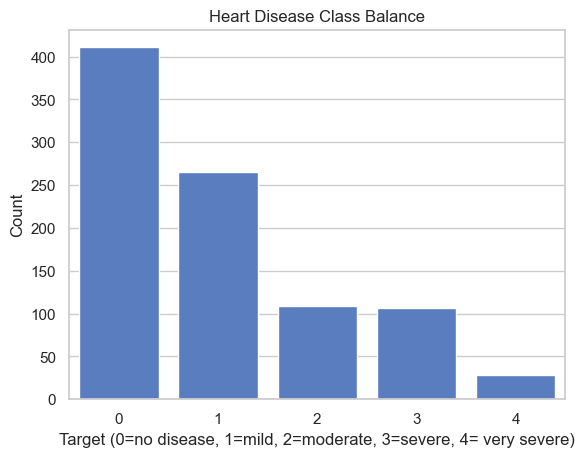

num
0    44.673913
1    28.804348
2    11.847826
3    11.630435
4     3.043478
Name: proportion, dtype: float64


In [6]:
target = "num"
sns.countplot(x=target, data=df)
plt.title("Heart Disease Class Balance")
plt.xlabel("Target (0=no disease, 1=mild, 2=moderate, 3=severe, 4= very severe)")
plt.ylabel("Count")
plt.show()

# Optional: percentage
print(df[target].value_counts(normalize=True) * 100)

About 45% of patients have num = 0 → no heart disease
The remaining 55% have num = 1–4 → some level of heart disease
So the dataset is not extremely imbalanced, but it’s also not perfectly balanced. Roughly 45% vs 55% if we convert it to a binary problem (target = 0 or 1).

1.7 Feature distributions (optional)

In [7]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove(target)

# df[numeric_features].hist(figsize=(15,10), bins=20)
# plt.suptitle("Numeric Feature Distributions")
# plt.show()

1.8 Correlation Heatmap

The correlation between a feature and the target variable (num) will tell us which features are important. 

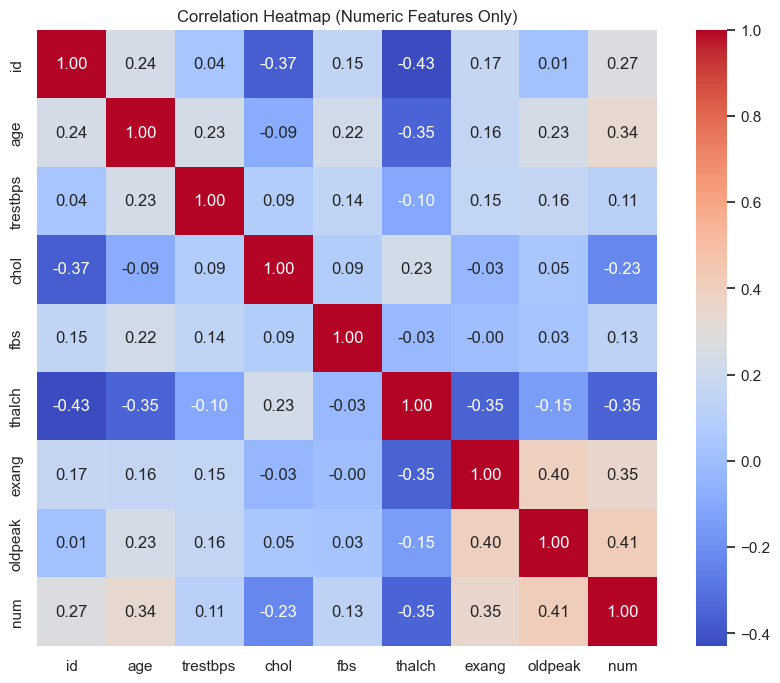

In [8]:
# Select only numeric columns
numeric_df = df_clean.select_dtypes(include=['float64', 'int64', 'bool'])

# Compute correlation
corr = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numeric Features Only)')
plt.show()

We can see that features such as: oldpeak, exang, fbs, trestbps and age, have a a positive correlation with the target variable

1.9 Boxplots for features by target

In [9]:
# for col in numeric_features:
#     plt.figure(figsize=(6,4))
#     sns.boxplot(x=target, y=col, data=df)
#     plt.title(f"{col} distribution by Heart Disease")
#     plt.show()


1.10 Optional: pairplot

In [10]:
# sns.pairplot(df, hue=target, vars=numeric_features[:5])  # first 5 features for clarity
# plt.show()

1.11 Convert the problem from multiclass to binary

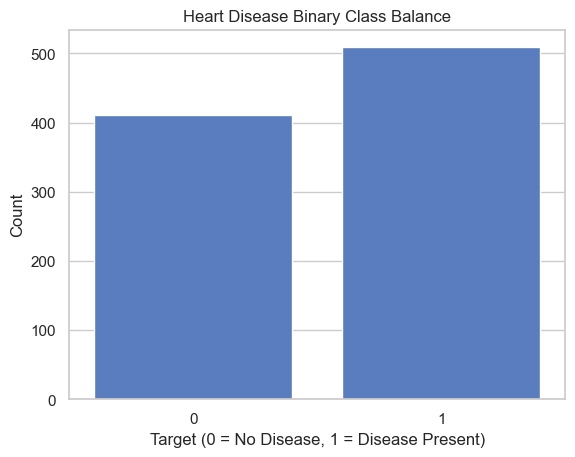

target
1    55.326087
0    44.673913
Name: proportion, dtype: float64


In [11]:
# Convert to binary classification
df_clean['target'] = df_clean['num'].apply(lambda x: 0 if x == 0 else 1)

# Verify distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=df_clean)
plt.title('Heart Disease Binary Class Balance')
plt.xlabel('Target (0 = No Disease, 1 = Disease Present)')
plt.ylabel('Count')
plt.show()

# Print percentages
print(df_clean['target'].value_counts(normalize=True) * 100)


Now its more clear for us to define our RQ: Can we predict whether a patient has heart disease based on clinical features, and which features contribute most to this prediction?


## Step 2 — Feature Engineering & Selection

2.1 Drop unused columns

In [12]:
df_model = df_clean.drop(columns=['id', 'num'])

In [13]:
df_model.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,target
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,1
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0


2.2 Identify column types

In [14]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang']
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak']

2.3 One-hot encode categorical columns

In [15]:
df_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

This converts categorical text variables into numeric dummy columns.

2.4 Scale numeric features

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_encoded[numeric_cols] = scaler.fit_transform(df_encoded[numeric_cols])

2.5 Split into train/test sets

In [17]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('target', axis=1)
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Verify shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (736, 14)
X_test shape: (184, 14)
y_train shape: (736,)
y_test shape: (184,)


## Step 3: Model Selection and Training

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, RocCurveDisplay
)
import joblib

sns.set(style="whitegrid")
%matplotlib inline

print("Imports done.")


Imports done.


3.1 Prepare features (X) and target (y)

In [19]:
# Quick checks
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Target distribution in train:", y_train.value_counts(normalize=True).to_dict())
print("Target distribution in test :", y_test.value_counts(normalize=True).to_dict())

X_train shape: (736, 14)
X_test shape: (184, 14)
Target distribution in train: {1: 0.5529891304347826, 0: 0.4470108695652174}
Target distribution in test : {1: 0.5543478260869565, 0: 0.44565217391304346}


Training and test sets are ready for preprocessing and the target is balanced.

3.2 Detect numeric columns with low cardinality to treat as categorical

In [20]:
cardinality_threshold = 10  # numeric columns with <=10 unique values are treated as categorical

# Identify numeric columns
numeric_candidates = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Detect numeric columns to cast
numeric_to_cast = [c for c in numeric_candidates if X_train[c].nunique(dropna=False) <= cardinality_threshold]
print("Numeric columns to cast as categorical:", numeric_to_cast)

# Cast these columns in both train and test sets
X_train = X_train.copy()
X_test = X_test.copy()
for c in numeric_to_cast:
    X_train[c] = X_train[c].astype(str)
    X_test[c] = X_test[c].astype(str)

# Verify dtypes
print("\nFeature types after casting:")
print(X_train.dtypes.value_counts())

Numeric columns to cast as categorical: []

Feature types after casting:
bool       8
float64    5
object     1
Name: count, dtype: int64


3.3 Build ColumnTransformer & Pipelines

Preprocessing pipeline that:

Scales numeric features

One-hot encodes categorical and boolean features

Can be combined with a classifier (Logistic Regression or Random Forest)

In [21]:
# --- Selectors ---
num_selector  = make_column_selector(dtype_include=np.number)
cat_selector  = make_column_selector(dtype_include=object)
bool_selector = make_column_selector(dtype_include=bool)

# --- Transformers ---
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# --- ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_selector),
        ("cat_obj", categorical_transformer, cat_selector),
        ("cat_bool", categorical_transformer, bool_selector)
    ],
    remainder='drop',       # drop any columns not selected
    sparse_threshold=0      # return dense array
)

# --- Pipelines ---
pipe_log = Pipeline([("pre", preprocessor),
                     ("clf", LogisticRegression(max_iter=1000, random_state=42))])

pipe_rf = Pipeline([("pre", preprocessor),
                    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))])

print("Pipelines ready for model training.")

Pipelines ready for model training.


3.4 GridSearchCV for Logistic Regression

What this does:

Tries all combinations of penalty and C with 5-fold CV.

Picks the hyperparameters that maximize ROC-AUC.

Preprocessing (scaling + one-hot) happens inside the pipeline, so no leakage occurs.

In [22]:
# --- Logistic Regression parameter grid ---
param_grid_log = {
    "clf__penalty": ["l1", "l2"],   # regularization type
    "clf__C": [0.01, 0.1, 1, 10],  # inverse of regularization strength
    "clf__solver": ["liblinear"]    # liblinear supports both l1 and l2
}

# --- GridSearchCV with 5-fold CV ---
gs_log = GridSearchCV(
    estimator=pipe_log,
    param_grid=param_grid_log,
    cv=5,
    scoring='roc_auc',   # robust for binary classification
    n_jobs=-1,
    verbose=1
)

# --- Fit GridSearchCV ---
gs_log.fit(X_train, y_train)

# --- Best params and CV score ---
print("Best Logistic Regression params:", gs_log.best_params_)
print("Best CV ROC-AUC:", gs_log.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression params: {'clf__C': 10, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best CV ROC-AUC: 0.8861540637421396


Accuracy: 0.8260869565217391
ROC-AUC: 0.9196556671449068

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80        82
           1       0.84      0.85      0.84       102

    accuracy                           0.83       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184

Confusion Matrix:
 [[65 17]
 [15 87]]


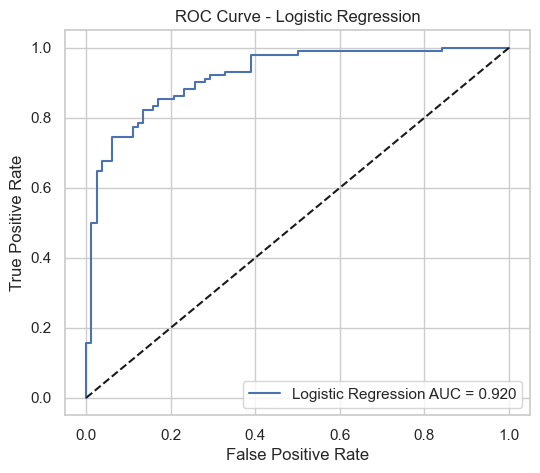

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# --- Get the best model ---
best_log = gs_log.best_estimator_

# --- Predictions and probabilities ---
y_pred = best_log.predict(X_test)
y_proba = best_log.predict_proba(X_test)[:, 1]  # probability of positive class

# --- Metrics ---
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Logistic Regression AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()


Interpretation:

Accuracy: ~82.6% → the model correctly predicts the outcome for ~83% of patients.

ROC-AUC: 0.92 → excellent discriminative ability between patients with and without heart disease.

[[65 17]   ← true 0 predicted as 0 vs misclassified
 [15 87]]  ← true 1 predicted as 1 vs misclassified

Only 32 misclassifications out of 184, which is solid.

3.5 Random Forest: GridSearchCV + Evaluation

In [24]:
# --- Random Forest parameter grid ---
param_grid_rf = {
    "clf__n_estimators": [100, 300],      # number of trees
    "clf__max_depth": [None, 5, 10],      # max tree depth
    "clf__min_samples_split": [2, 5]      # minimum samples per split
}

# --- GridSearchCV for RF ---
gs_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# --- Fit GridSearchCV ---
gs_rf.fit(X_train, y_train)

# --- Best params and CV score ---
print("Best Random Forest params:", gs_rf.best_params_)
print("Best CV ROC-AUC:", gs_rf.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Random Forest params: {'clf__max_depth': 5, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
Best CV ROC-AUC: 0.878349248864154


Random Forest Accuracy: 0.8369565217391305
Random Forest ROC-AUC: 0.9197752271640363

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81        82
           1       0.83      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184

Confusion Matrix:
 [[64 18]
 [12 90]]


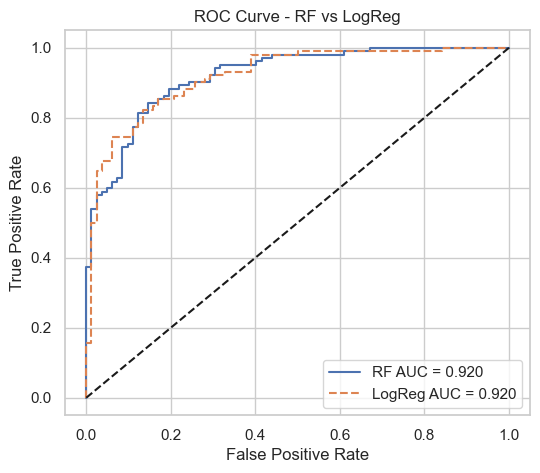

In [25]:
# Get best RF model
best_rf = gs_rf.best_estimator_

# Predictions & probabilities
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]

# Metrics
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr_rf, tpr_rf, label=f"RF AUC = {roc_auc_score(y_test, y_proba_rf):.3f}")
plt.plot(fpr, tpr, label=f"LogReg AUC = {roc_auc_score(y_test, y_proba):.3f}", linestyle='--')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RF vs LogReg")
plt.legend()
plt.show()

# Save the best model (choose between best_log and best_rf)
# final_model = best_rf  # or best_log
# model_filename = os.path.join(DATA_DIR, "heart_disease_model.joblib")
# joblib.dump(final_model, model_filename)
# print(f"Model saved to {model_filename}")

Random Forest performance

Accuracy: ~83.7% → slightly higher than Logistic Regression (~82.6%).

ROC-AUC: 0.92 → virtually identical to Logistic Regression (0.9197 vs 0.9196).

Precision / Recall:

Class 0 (no disease): precision 0.84, recall 0.78 → a few more false negatives.

Class 1 (disease): precision 0.83, recall 0.88 → better recall for diseased patients than Logistic Regression.

Confusion Matrix: Only 30 misclassifications, slightly better detection of diseased patients.

#### Comparison with Logistic Regression

Both models have very similar ROC-AUC (~0.92), which indicates excellent discrimination.

Random Forest slightly improves recall for diseased patients, which can be important in a medical context (catch more true positives).

Logistic Regression is simpler and interpretable; Random Forest can capture non-linear relationships.

3.6 Feature Importances / Coefficients

In [26]:
def get_feature_names_from_preprocessor(fitted_preprocessor, X_sample):
    feat_names = []
    for name, trans, cols in fitted_preprocessor.transformers_:
        if name == 'remainder':
            continue
        # resolve callable selector to column names
        if callable(cols):
            cols = cols(X_sample)
        if isinstance(trans, StandardScaler):
            feat_names.extend(cols)
        elif isinstance(trans, OneHotEncoder):
            ohe = trans
            cats = ohe.categories_
            for col, cats_for_col in zip(cols, cats):
                cats_to_use = list(cats_for_col)[1:] if getattr(ohe, "drop", None) is not None else list(cats_for_col)
                for cat in cats_to_use:
                    feat_names.append(f"{col}_{cat}")
        else:
            feat_names.extend(cols)
    return feat_names

# --- get fitted preprocessor from the pipeline ---
fitted_preprocessor_log = best_log.named_steps['pre']
fitted_preprocessor_rf = best_rf.named_steps['pre']

# --- extract feature names ---
feature_names_log = get_feature_names_from_preprocessor(fitted_preprocessor_log, X_train)
feature_names_rf  = get_feature_names_from_preprocessor(fitted_preprocessor_rf, X_train)

print("Number of features after preprocessing:", len(feature_names_log))
print("First 20 feature names:", feature_names_log[:20])


Number of features after preprocessing: 16
First 20 feature names: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'dataset_Hungary', 'dataset_Switzerland', 'dataset_VA Long Beach', 'sex_Male_True', 'cp_atypical angina_True', 'cp_non-anginal_True', 'cp_typical angina_True', 'fbs_True_True', 'restecg_normal_True', 'restecg_st-t abnormality_True', 'exang_True_True']


In [27]:
coef = best_log.named_steps['clf'].coef_[0]
coef_df = pd.DataFrame({"feature": feature_names_log, "coef": coef})
# Sort by absolute value of coefficients
coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values(by="abs_coef", ascending=False)

print("Top 10 most important features (Logistic Regression):")
print(coef_df.head(10).drop(columns="abs_coef"))


Top 10 most important features (Logistic Regression):
                    feature      coef
6       dataset_Switzerland  3.288014
9   cp_atypical angina_True -1.904277
8             sex_Male_True  1.282339
10      cp_non-anginal_True -1.101274
11   cp_typical angina_True -1.063010
15          exang_True_True  1.047578
7     dataset_VA Long Beach  0.667923
4                   oldpeak  0.637469
12            fbs_True_True  0.447190
13      restecg_normal_True -0.367614


In [28]:
importances = best_rf.named_steps['clf'].feature_importances_
rf_feat_df = pd.DataFrame({"feature": feature_names_rf, "importance": importances})
rf_feat_df = rf_feat_df.sort_values('importance', ascending=False)

print("Top 10 most important features (Random Forest):")
print(rf_feat_df.head(10))


Top 10 most important features (Random Forest):
                    feature  importance
15          exang_True_True    0.169474
4                   oldpeak    0.139443
9   cp_atypical angina_True    0.136004
3                    thalch    0.124686
0                       age    0.094727
2                      chol    0.088740
6       dataset_Switzerland    0.059707
8             sex_Male_True    0.055742
10      cp_non-anginal_True    0.035161
1                  trestbps    0.029897


In [29]:
# Save the entire pipeline including preprocessing and classifier
joblib.dump(best_log, "../logistic_regression_heart_model.pkl")

print("Logistic Regression model saved as 'logistic_regression_heart_model.pkl'")

Logistic Regression model saved as 'logistic_regression_heart_model.pkl'


Intrepretation:
Analysis:

Performance: Both models perform almost identically in terms of ROC-AUC (0.9197 vs 0.9198) — very strong discriminative power. Random Forest has slightly better recall for diseased patients, which is important in medical diagnostics (better at catching true positives).

Interpretability: Logistic Regression is fully interpretable; coefficients can be mapped to clinical features. Random Forest is less interpretable, though feature importances help.

Clinical use: For deployment in a hospital or research setting, interpretability is often valuable, especially if you want clinicians to trust and understand the model.

✅ Verdict:

If you prioritize slightly better predictive power → Random Forest.

If you prioritize interpretability and clinical insight → Logistic Regression.

Given how close the performance is, Logistic Regression is a strong choice because it balances accuracy and interpretability — and the important clinical features (exang, oldpeak, age, sex) are clearly visible.